In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack

import utils

In [2]:
X_train, y_train, X_test, y_test = utils.load_mnist()

In [8]:
# Let's do the fft manually and see what we get
def manualfft(image):
    dctimage = np.zeros(image.shape)
    ksum = 0
    N1 = image.shape[0]
    N2 = image.shape[1]
    
    mult1 = np.pi / N1
    mult2 = np.pi / N2
    for k1 in range(image.shape[0]):
        for k2 in range(image.shape[1]):
            for n1 in range(N1):
                for n2 in range(N2):
                    ksum += image[n1, n2]*np.cos(mult1*(n1+0.5)*k1)*np.cos(mult2*(n2+0.5)*k2)
            dctimage[k1][k2] = ksum
            ksum = 0
            
    return dctimage

In [9]:
def manualdct(image, inverse=False):
    N1 = image.shape[0]
    N2 = image.shape[1]
    
    x = np.transpose(np.tile(np.arange(1,N1+1,1, dtype=float), 28).reshape(N2,N1))
    y = np.tile(np.arange(1,N2+1,1, dtype=float), N1).reshape(N1,N2)
    
    dctImage = np.zeros((N1, N2), dtype=float)
    
    for i in range(1,N1+1):
        for j in range(1,N2+1):
            
            mult1, mult2 = 1, 1
#             if (i == 1):
#                 mult1 = np.sqrt(1 / N1)
#             else:
#                 mult1 = np.sqrt(2 / N1)
            
#             if (j == 1):
#                 mult2 = np.sqrt(1 / N2)
#             else:
#                 mult2 = np.sqrt(2 / N2)
            
            cs1 = np.cos((np.pi*(2*x-1) * (i-1)) / (2*N1))
            cs2 = np.cos((np.pi*(2*y-1) * (j-1)) / (2*N2))
            
            if inverse:
                temp = image * cs1 * cs2 * mult1 * mult2

                dctImage[i-1,j-1] = temp.sum().item()
            else:
                temp = image * cs1 * cs2
                
                dctImage[i-1, j-1] = temp.sum().item() * mult1 * mult2
    
    return dctImage

In [5]:
manualdctimage = manualdct(X_train[0].squeeze(0))

In [6]:
manualfftimage = manualfft(X_train[0].squeeze(0))

In [7]:
# Time to compute scipy implementation
%timeit fftpack.dct(X_train[0].squeeze(0))

13.2 µs ± 131 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [8]:
# Time to compute manualfft
%timeit manualfft(X_train[0].squeeze(0))

2.02 s ± 30.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
# Time to compute manualdct
%timeit manualdct(X_train[0].squeeze(0))

23.2 ms ± 186 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
print(manualdctimage.min())
print(manualdctimage.max())
print(manualfftimage.min())
print(manualfftimage.max())

-70.94374450657244
107.94117754790932
-70.94374450657244
107.94117754790932


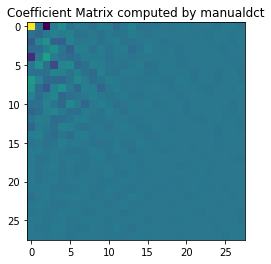

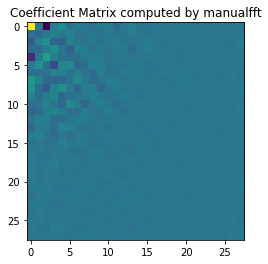

In [11]:
plt.imshow((manualdctimage - manualdctimage.min()) / (manualdctimage.max() - manualdctimage.min()))
plt.title("Coefficient Matrix computed by manualdct")
plt.show()

plt.imshow((manualfftimage - manualfftimage.min()) / (manualfftimage.max() - manualfftimage.min()))
plt.title("Coefficient Matrix computed by manualfft")
plt.show()

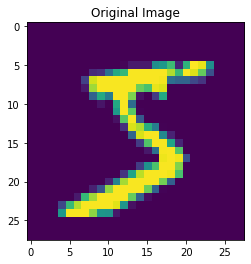

In [12]:
idx = 0
sample = X_train[idx].squeeze(0)

plt.imshow(sample)
plt.title("Original Image")
plt.show()

In [13]:
manualdctimage = manualdct(sample)

Deleted block size: 27x27


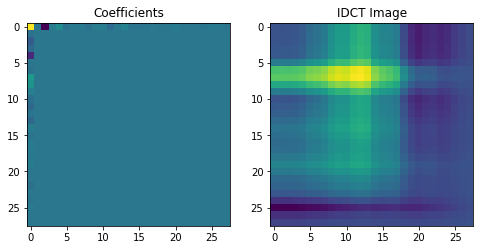

Deleted block size: 24x24


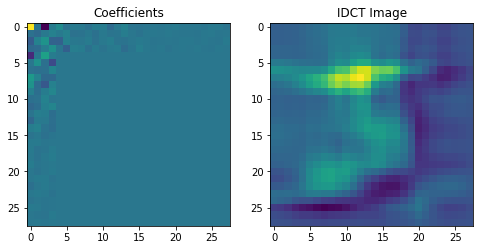

Deleted block size: 21x21


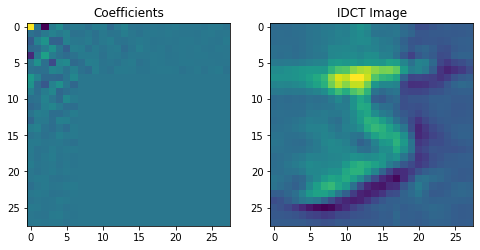

Deleted block size: 18x18


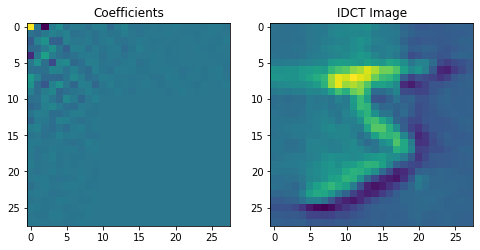

Deleted block size: 15x15


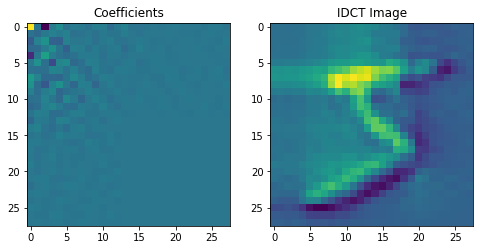

Deleted block size: 12x12


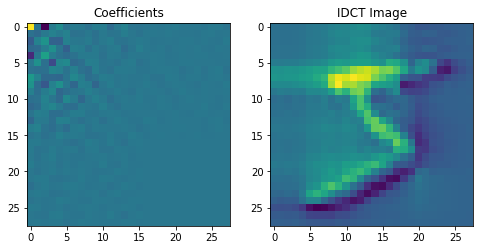

Deleted block size: 9x9


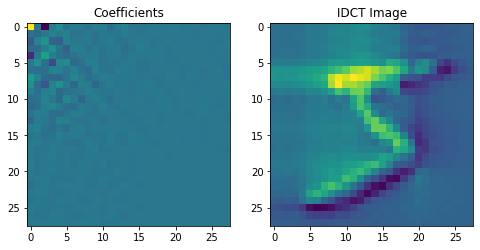

Deleted block size: 6x6


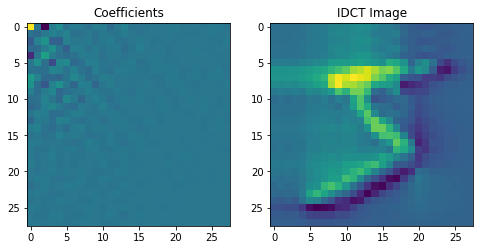

Deleted block size: 3x3


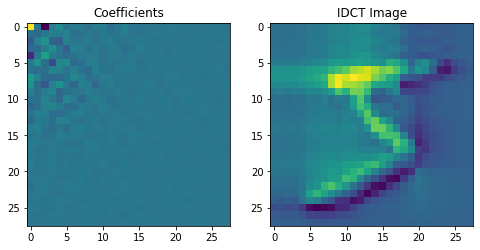

In [14]:
for i in range(1,28,3):
    coefficients = np.copy(manualdctimage)
    coefficients[i:, i:] = 0
    image = manualdct(coefficients, True)
    print("Deleted block size: %dx%d" % (28 - i, 28 - i))
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=[8,8])
    ax1.imshow((coefficients - coefficients.min()) / (coefficients.max() - coefficients.min()))
    ax1.set_title("Coefficients")
    
    ax2.imshow((image - image.min()) / (image.max() - image.min()))
    ax2.set_title("IDCT Image")
    plt.show()

In [3]:
from DCTDimReducer import DCTDimReducer

train_data = X_train
test_data = X_test

In [4]:
n = 15

dct = DCTDimReducer(input_image_shape=[28,28], coef_size_reduction=n)
idct = DCTDimReducer(input_image_shape=[28,28], coef_size_reduction=n, inverse=True)

In [5]:
train_coefficients = dct.fit_transform(train_data)
test_coefficients = dct.fit_transform(test_data)

In [6]:
train_coefficients.shape

(60000, 559)

In [7]:
train_inverses = idct.fit_transform(train_coefficients)
test_inverses = idct.fit_transform(test_coefficients)

In [8]:
for i in range(train_inverses.shape[0]):
    train_inverses[i] = (train_inverses[i] - train_inverses[i].min()) / (train_inverses[i].max() - train_inverses[i].min())
    
for i in range(test_inverses.shape[0]):
    test_inverses[i] = (test_inverses[i] - test_inverses[i].min()) / (test_inverses[i].max() - test_inverses[i].min())

train_inverses = train_inverses.reshape([train_inverses.shape[0], 1, 28, 28])
test_inverses = test_inverses.reshape([test_inverses.shape[0], 1, 28, 28])

print(train_inverses.min())
print(train_inverses.max())
print(test_inverses.min())
print(test_inverses.max())
print(train_inverses.shape)
print(test_inverses.shape)

0.0
1.0
0.0
1.0
(60000, 1, 28, 28)
(10000, 1, 28, 28)


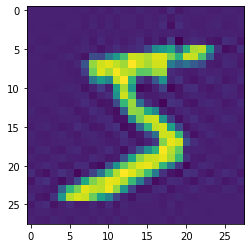

In [9]:
plt.imshow(train_inverses[0].squeeze())
plt.show()

In [10]:
from model import My_VGG as Model
import torch
from torch import nn, optim
from time import time

def train_model(model, optimizer, x_train, x_test, y_train, y_test, epochs=15):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    trainset = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train).type(torch.long))
    valset = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test).type(torch.long))
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

    criterion = nn.NLLLoss()
    
    if device == "cuda":
        model = model.cuda()
    model.train()
    
    time0 = time()
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)
    
    model.eval()
    correct_count, all_count = 0, 0
    for x, y in valloader:
        all_count += y.shape[0]
        x, y = x.to(device), y.to(device)
        output = model(x)
        preds = output.max(1)[1]
        correct_count += preds.eq(y).sum().item()
    model.to("cpu")

    print("Number Of Images Tested =", all_count)
    print("\nModel Accuracy =", (correct_count/all_count))
    
    return model, optimizer

In [11]:
channels = 1
size = 28
classes = 10

# # Create model and optimizer
# model = Model(in_channels=channels, in_size=in_size, num_classes=num_classes)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Train base model
# epochs = 15
# model, optimizer = train_model(model, optimizer, train_inverses, test_inverses, y_train, y_test, epochs=epochs)

# Save trained model
PATH = 'trained_models/dct_model.pt'

# torch.save({'epoch': epochs,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'in_channels': channels,
#             'in_size': size,
#             'num_classes': classes
#             }, PATH)

model = utils.load_VGG(PATH)

In [12]:
attacked_model = utils.load_VGG('trained_models/initial_model.pt')

test_dataloader = utils.create_dataloader(X_test, y_test)
adv_test_data = utils.add_adversarial_noise(attacked_model, test_dataloader, eps=.04)

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [13]:
dct_adv_test_data = dct.fit_transform(adv_test_data)
inverse_dct_adv_test_data = idct.fit_transform(dct_adv_test_data).reshape(-1,1,28,28)

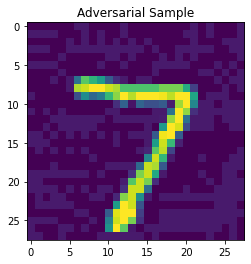

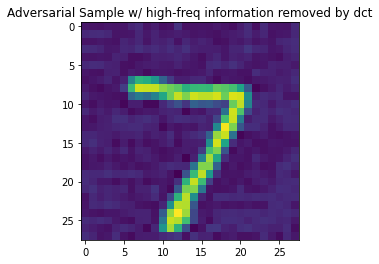

In [14]:
idx = 0

plt.imshow(adv_test_data[idx].squeeze())
plt.title("Adversarial Sample")
plt.show()

plt.imshow(inverse_dct_adv_test_data[idx].squeeze())
plt.title("Adversarial Sample w/ high-freq information removed by dct")
plt.show()

In [15]:
print("Accuracy on plain clean data: %f" % (utils.eval_model(model, X_test, y_test) * 100))
print("Accuracy on dct clean data: %f" % (utils.eval_model(model, test_inverses, y_test) * 100))

print("Accuracy on plain adversarial data: %f" % (utils.eval_model(model, adv_test_data, y_test) * 100))
print("Accuracy on dct adversarial data: %f" % (utils.eval_model(model, inverse_dct_adv_test_data, y_test) * 100))

Accuracy on plain clean data: 99.250000
Accuracy on dct clean data: 99.290000
Accuracy on plain adversarial data: 98.910000
Accuracy on dct adversarial data: 28.440000
